# Observe Viability Predictions against DepMap Estimates

In [1]:
import os
import pandas as pd
from scipy import stats

import plotnine as gg

In [2]:
%matplotlib inline

In [3]:
cell_line_id = "A549_LUNG"
cell_health_model = "cell_health_modz_target_cc_cc_n_objects"

## Load Data

### Cancer Dependency Map Data

In [4]:
depmap_file = os.path.join(
    "data",
    "processed",
    "{}_viability_estimates.tsv".format(cell_line_id)
)

depmap_df = (
    pd.read_csv(depmap_file, sep='\t')
    .rename(
        {
            cell_line_id: "depmap_viability"
        },
        axis="columns"
    )
)

print(depmap_df.shape)
depmap_df.head(3)

(17694, 14)


,treatment_id,depmap_viability,broad_id,column_name,disease.area,dose,indication,moa,name,phase,screen_id,smiles,target,dose_recode
0,BRD-A00077618-236-07-6::2.5::HTS,-0.253541,BRD-A00077618-236-07-6,BRD-A00077618-236-07-6::2.5::HTS,NaN,2.5,NaN,PKA activator,8-bromo-cGMP,Preclinical,HTS,Nc1nc(O)c2nc(Br)n([C@@H]3O[C@@H]4COP(O)(=O)O[C...,PRKG1,5
1,BRD-A00100033-001-08-9::2.5::HTS,-0.506751,BRD-A00100033-001-08-9,BRD-A00100033-001-08-9::2.5::HTS,infectious disease,2.5,"Chagas disease, African trypanosomiasis",DNA inhibitor,nifurtimox,Launched,HTS,CC1CS(=O)(=O)CCN1N=Cc1ccc(o1)[N+]([O-])=O,NaN,5
2,BRD-A00147595-001-01-5::2.5::HTS,-0.477851,BRD-A00147595-001-01-5,BRD-A00147595-001-01-5::2.5::HTS,NaN,2.5,NaN,"insulin sensitizer, PPAR receptor partial agonist",balaglitazone,Phase 3,HTS,Cn1c(COc2ccc(CC3SC(=O)NC3=O)cc2)nc2ccccc2c1=O,PPARG,5


### Cell Health Predictions on Drug Repurposing Hub

In [5]:
focus_columns = [
    "Metadata_Plate_Map_Name",
    "Metadata_broad_sample",
    "Metadata_dose_recode",
    "Metadata_mmoles_per_liter",
    "Metadata_pert_well",
    cell_health_model
]

In [6]:
cell_health_file = os.path.join(
    "..",
    "4.apply",
    "data",
    "repurposing_transformed_real_models_modz.tsv.gz"
)

cell_health_df = (
    pd.read_csv(cell_health_file, sep='\t')
    #.loc[:, focus_columns]
    .rename(
        {
            cell_health_model: "cell_health_viability"
        },
        axis="columns"
    )
)

print(cell_health_df.shape)
cell_health_df.head(3)

(10368, 75)


,Metadata_Plate_Map_Name,Metadata_broad_sample,Metadata_pert_well,Metadata_mmoles_per_liter,Metadata_dose_recode,cell_health_modz_target_cc_late_mitosis_n_spots_h2ax_per_nucleus_area_mean,cell_health_modz_target_cc_all_nucleus_roundness_mean,cell_health_modz_target_cc_polyploid_n_objects,cell_health_modz_target_cc_g1_n_objects,cell_health_modz_target_cc_mitosis_n_objects,...,cell_health_modz_target_cc_s_intensity_nucleus_area_mean,cell_health_modz_target_cc_g2_high_h2ax,cell_health_modz_target_cc_late_mitosis_n_spots_h2ax_mean,cell_health_modz_target_cc_cc_high_h2ax,cell_health_modz_target_vb_percent_dead_only,cell_health_modz_target_cc_s_high_h2ax,cell_health_modz_target_cc_cc_n_spots_h2ax_per_nucleus_area_mean,cell_health_modz_target_cc_s_n_spots_h2ax_per_nucleus_area_mean,cell_health_modz_target_cc_g1_plus_g2_count,cell_health_modz_target_vb_live_cell_width_length
0,C-7161-01-LM6-001,BRD-A25234499-001-18-3,B13,10.0000,6,0.121840,0.287876,0.332128,0.031668,0.293513,...,-0.041590,0.275196,0.231984,0.034737,0.226777,0.237375,0.105485,0.153677,-0.530986,0.144455
1,C-7161-01-LM6-001,BRD-A25234499-001-18-3,B14,3.3333,5,0.135517,-0.016983,0.175805,0.045467,0.271201,...,-0.615482,0.516950,0.242159,0.012577,0.632890,0.399858,0.022915,0.202797,-0.159769,-0.294545
2,C-7161-01-LM6-001,BRD-A25234499-001-18-3,B15,1.1111,4,0.181414,0.029788,0.205290,0.009674,0.302538,...,-0.577316,0.401250,0.268255,0.080886,0.207432,0.337209,0.180617,0.285974,-0.254186,-0.048311


## Observe how different dose recodings are

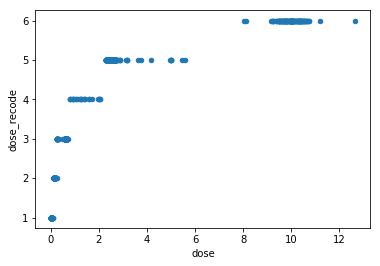

In [7]:
depmap_df.plot(x="dose", y="dose_recode", kind="scatter")

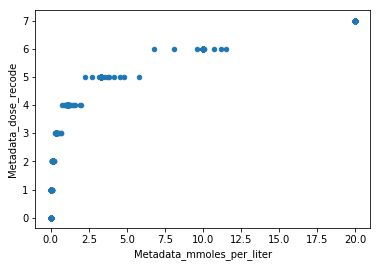

In [8]:
cell_health_df.plot(x="Metadata_mmoles_per_liter", y="Metadata_dose_recode", kind="scatter")

## Merge Together

In [9]:
full_df = (
    cell_health_df
    .merge(
        depmap_df,
        left_on=["Metadata_broad_sample", "Metadata_dose_recode"],
        right_on=["broad_id", "dose_recode"],
        how="inner"
    )
    .dropna(subset=["depmap_viability"])
)

print(full_df.shape)
full_df.head(3)

(5977, 89)


,Metadata_Plate_Map_Name,Metadata_broad_sample,Metadata_pert_well,Metadata_mmoles_per_liter,Metadata_dose_recode,cell_health_modz_target_cc_late_mitosis_n_spots_h2ax_per_nucleus_area_mean,cell_health_modz_target_cc_all_nucleus_roundness_mean,cell_health_modz_target_cc_polyploid_n_objects,cell_health_modz_target_cc_g1_n_objects,cell_health_modz_target_cc_mitosis_n_objects,...,disease.area,dose,indication,moa,name,phase,screen_id,smiles,target,dose_recode
0,C-7161-01-LM6-001,BRD-A25234499-001-18-3,B13,10.0000,6,0.121840,0.287876,0.332128,0.031668,0.293513,...,"endocrinology, oncology",10.0,"Cushing's syndrome, breast cancer",glucocorticoid receptor antagonist,aminoglutethimide,Launched,HTS002,"CCC1(CCC(=O)NC1=O)c1ccc(N)cc1, CCC1(CCC(=O)NC1...","CYP11A1, CYP19A1",6
1,C-7161-01-LM6-001,BRD-A25234499-001-18-3,B14,3.3333,5,0.135517,-0.016983,0.175805,0.045467,0.271201,...,"endocrinology, oncology",2.5,"Cushing's syndrome, breast cancer",glucocorticoid receptor antagonist,aminoglutethimide,Launched,HTS,"CCC1(CCC(=O)NC1=O)c1ccc(N)cc1, CCC1(CCC(=O)NC1...","CYP11A1, CYP19A1",5
2,C-7161-01-LM6-001,BRD-A25234499-001-18-3,B14,3.3333,5,0.135517,-0.016983,0.175805,0.045467,0.271201,...,"endocrinology, oncology",2.5,"Cushing's syndrome, breast cancer",glucocorticoid receptor antagonist,aminoglutethimide,Launched,HTS002,"CCC1(CCC(=O)NC1=O)c1ccc(N)cc1, CCC1(CCC(=O)NC1...","CYP11A1, CYP19A1",5


/Users/gway/miniconda3/envs/cell-health/lib/python3.7/site-packages/plotnine/ggplot.py:706: UserWarning: Saving 3 x 3 in image.
  from_inches(height, units), units))
/Users/gway/miniconda3/envs/cell-health/lib/python3.7/site-packages/plotnine/ggplot.py:707: UserWarning: Filename: figures/dose_differences.png
  warn('Filename: {}'.format(filename))


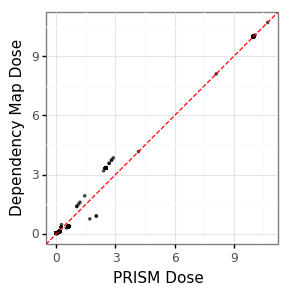

<ggplot: (-9223372036559798079)>

In [10]:
dose_differences_gg = (
    gg.ggplot(full_df, gg.aes(x="dose", y="Metadata_mmoles_per_liter")) +
    gg.geom_point(size = 0.5, alpha = 0.6) +
    gg.theme_bw() +
    gg.geom_abline(slope=1, intercept=0, linetype="dashed", color="red") +
    gg.xlab("PRISM Dose") +
    gg.ylab("Dependency Map Dose") +
    gg.coord_fixed()
)

output_file = os.path.join("figures", "dose_differences.png")
dose_differences_gg.save(output_file, dpi = 400, height = 3, width = 3)

dose_differences_gg

## Obtain Results

In [11]:
spearman_cor = stats.spearmanr(full_df.cell_health_viability, full_df.depmap_viability)
spearman_cor = pd.DataFrame(spearman_cor, index=["stat", "p"]).transpose()
spearman_cor

,stat,p
0,0.345139,8.185456e-167


In [12]:
result_text = "Spearman = {0:.2f}\np = {1:.2E}".format(
    spearman_cor.stat[0],
    spearman_cor.p[0]
)

result_text

'Spearman = 0.35\np = 8.19E-167'

/Users/gway/miniconda3/envs/cell-health/lib/python3.7/site-packages/plotnine/ggplot.py:706: UserWarning: Saving 5 x 3 in image.
  from_inches(height, units), units))
/Users/gway/miniconda3/envs/cell-health/lib/python3.7/site-packages/plotnine/ggplot.py:707: UserWarning: Filename: figures/viability_results.png
  warn('Filename: {}'.format(filename))
/Users/gway/miniconda3/envs/cell-health/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/Users/gway/miniconda3/envs/cell-health/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


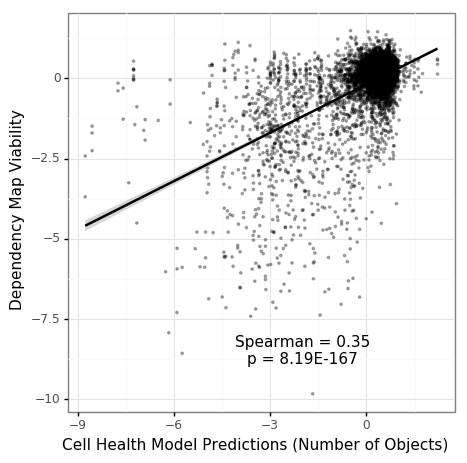

<ggplot: (295070847)>

In [13]:
viability_gg = (
    gg.ggplot(full_df, gg.aes(x="cell_health_viability", y="depmap_viability")) +
    gg.geom_point(size = 0.5, alpha = 0.3) +
    gg.theme_bw() +
    gg.geom_smooth() +
    gg.annotate("text", label = result_text, x = -2, y = -8.5) +
    gg.xlab("Cell Health Model Predictions (Number of Objects)") +
    gg.ylab("Dependency Map Viability") +
    gg.coord_fixed()
)

output_file = os.path.join("figures", "viability_results.png")
viability_gg.save(output_file, dpi = 400, height = 3, width = 5)

viability_gg